# Hypothèses de travail

- On a un graph de connexion que l'on connait au niveau de la passerelle avec une précision plus ou moins grande. On connait au moins les noeuds mais on ne connait pas forcement les arêtes (route ou bien lien radios) entre les noeuds.

- Cette information est juste indispensable pour connaitre les impacts de restrictions de traffic via le cache sur l'ensemble des noeuds.

,battery,freq_min,freq_max,t_request
nodes,,,,
0,100,1,9,1
1,100,1,9,1
2,100,1,9,1
3,100,1,9,1
4,100,1,9,1
5,100,1,9,1
6,100,1,9,1
7,100,1,9,1
8,100,1,9,1


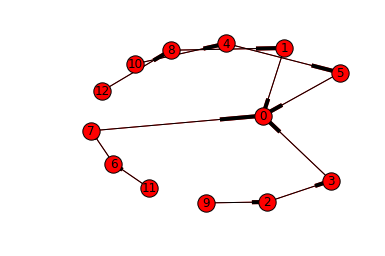

In [1]:
%matplotlib inline

import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Typical balanced topology
g = nx.DiGraph()
g.add_edges_from([(1, 0), (3, 0), (5, 0), (7, 0), 
                  (2, 3), (4, 5), (6, 7), (8, 1),
                  (10, 4), (11, 6), (12, 8), (9, 2)])

# Dessin du graphe
pos = nx.spring_layout(g)
nx.draw_networkx_labels(g, pos=pos)
nx.draw_networkx_edges(g, pos, edge_color='r', arrows=True)

# On ajoute des attributs aléatoires au noeuds
g.add_nodes_from([(node_id, {
                "battery": 100, 
                "freq_min": 1,
                "t_request": 1,
                "freq_max": 9}) for node_id in g.nodes()])

N = len(g.nodes())

# On met toutes ces données dans un joli tableau
df = pd.DataFrame(index=pd.Index(g.nodes(), name="nodes"))
for attribute in ["battery", "freq_min", "freq_max", "t_request"]:
    temp = nx.get_node_attributes(g, attribute)
    temp_df = pd.DataFrame.from_dict(temp, orient="index").rename(columns={0: attribute})
    df = df.join(temp_df)

# Dessin
nx.draw(g, pos=pos)

# Tableau
df

- Battery: (noté $b_i$) Représente le budget d'énergie que nous avons a notre disposition. Un noeud est considéré comme mort ssi son budget est nul.

- freq_min: (noté $f_{min}$) La fréquence minimale a partir de laquelle il faut redemander une information. Typiquement la température d'une pièce a probablement changé au bout d'une heure, il nous faut une fréquence de $f_{min} = \frac{1}{60}$ Hz.

- freq_max: (noté $f_{max}$) La fréquence maximale a partir de laquelle ça n'a plus de sens de demander plus souvent une information. Typiquement la temperature d'une pièce n'a pas changé en une seconde par conséquent la fréquence max est de $f_{max} = 1$ Hz.

- lifetime: (noté $l_i$) est le temps de vie qu'un utilisateur fixe pour un noeud donné. 

# Matrice d'impact

Nous souhaitons pouvoir déduire comment une frequence de requête sur un noeud va affecter les autres. Par conséquent nous souhaitons trouver une matrice qui peut facilement nous aider via un vecteur de requêtes d'entrée, trouver le nombre de requetes véritablement traitées en prenant en compte le forwarding.

Soit A la matrice d'adjacence du graphe $G$ que nous étudions. Il suffit de calculer :
l'inverse de $Id - A$...
Comme $A$ est nilpotente, $Id - A$ est forcément inversible et on a $(Id - A)^{-1} = Id + A + A^2 + ...$

In [2]:
def impact_matrix(g):
    """
    La matrice d'impact va nous donner la somme aggrégées des frequences de requetes
    admissibles pour un noeud en tenant compte des voisins.
    """
    nodes = sorted(g.nodes())
    n = len(nodes)
    adj_matrix = nx.adjacency_matrix(g, nodelist=nodes).T
    return ((np.identity(n) - adj_matrix) ** (-1))

# Si on prends une requête du noeud 5, elle va impacter les noeuds 0, 2 et 5
#impact_matrix(g) * np.array([0, 0, 0, 0, 0, 1, 0]).reshape((7,1))

# Resolution par un problème d'optimisation linéaire

- Pour toutes les frequences que l'on désire trouver on sait qu'il existe des bornes sur les fréquences :
$$\forall f_i, \exists (f_{min}, f_{max}) : f_{min} \leq f_i \leq f_{max} $$

- Pour chaque frequence cumulée sur un noeud on sait que l'on a l'inégalité suivante dans le cas où la fréquence est admissible :

$$ f_{i} \leq \frac{b_i}{l_i c_i}$$

où 

$b_i$ représente la batterie disponible sur le noeud $i$,

$l_i$ représente l'objectif de durée de vie imposée par l'utilisateur

$c_i$ représente le cout par paquet (peut être mis a jour dynamiquement).

Cette fréquence est une *borne sup*. La quantité maximale de requêtes qu'un sytème peut gérer.

## Problématiques

Il y a deux problèmes principaux:

### Avec une durée de vie fixée, 

- Fonction économique pour une durée de vie donnée et des performances aussi réactives que possible
$$max(\sum f_i)$$

- Fonction économique pour augmenter les temps de cache et augmenter la durée de vie autant que possible
$$min(\sum f_i)$$



In [3]:
#from scipy.optimize import linprog

# On considère que toutes les frequences se valent. Il pourrait être intéressant d'avoir des fonctions économiques
# plus évoluées. Par exemple on pourrait penser a des distributions de fréquences qui respectent la demande
# des requêtes pour un contenu particulier. C'est le temple de l'arbitraire mieux vaut ne pas y passer trop de temps.

#c = np.ones(len(g.nodes()))
#A = impact_matrix(g)

# Frequence minimale et maximale. Ça n'a pas beaucoup de sens de considerer une frequence de 300 milliards de requetes
# par secondes et ça n'a pas beaucoup de sens non plus de mettre en cache une requete pour un millineaire.

#bounds = [(elem_min, elem_max) for (elem_min, elem_max) in zip(df.freq_min, df.freq_max)]
#b = (df.battery / (df.lifetime * df.cost_per_packet)).sort_index()

# Where all the magic happen.
#res = linprog(-1 * c, A_ub=A, b_ub=b, bounds=bounds, options={"disp": True})
#freq = pd.DataFrame(res.x, index=pd.Index(g.nodes(), name="nodes"), columns=["freq"])

#df["freq"] = freq
#df["satisfaction"] = (df.freq_max - df.freq) / (df.freq_max - df.freq_min)
#df["cache_time"] = 1 / freq
df

,battery,freq_min,freq_max,t_request
nodes,,,,
0,100,1,9,1
1,100,1,9,1
2,100,1,9,1
3,100,1,9,1
4,100,1,9,1
5,100,1,9,1
6,100,1,9,1
7,100,1,9,1
8,100,1,9,1


In [4]:
import redis
import time

r = redis.Redis()

ttl_min = df.c_min.to_dict()
ttl_max = df.c_max.to_dict()

def test_ttl(ttl, prefix=None):
    if prefix is None:
        prefix = ""
    for request_id in range(1000):
        uri = np.random.choice(list(ttl.keys()))
        if r.exists(prefix + uri):
            print(request_id, uri, "h")
        else:
            # Faire la requête CoAP ici
            r.setex(name=prefix + uri, time=ttl[uri], value="Hello World")
            print(request_id, uri, "m")
        sleep_time = np.random.exponential()
        time.sleep(sleep_time)

# We add a prefix to don't have key conflict in case of parallel simulations
test_ttl(ttl_max, prefix="ttl_max")
test_ttl(ttl_min, prefix="ttl_min")

AttributeError: 'DataFrame' object has no attribute 'c_min'

## Optimisation multi-objectifs

In [9]:
def ratio(c, t):
    if t <= c:
        return np.ceil(c / t) * t
    else:
        return t
rfunc = np.vectorize(ratio)

### Définition de la durée de vie du réseau

C'est dans cette fonction que l'on va utiliser la topologie du réseau ainsi que la durée de cache pour calculer une durée de vie

In [6]:
import numpy as np

# Settings

Vdd = 3
I_tx = 11.6e-3
I_sleep = 80e-9
I_idle = 396e-6
I_rx = 12.7e-3
I_sleep_idle = 691e-12
I_idle_tx = 6.63e-6
I_idle_rx = 6.63e-6
P_tx = I_tx * Vdd
P_sleep = I_sleep * Vdd
P_idle = I_idle * Vdd
P_rx = I_rx * Vdd

Energy = Vdd * 3 * 3600

# Communications settings

R = 250000
L_get = 87 * 8
L_Ans = 96 * 8
S_get = L_get / R
S_Ans = L_Ans / R
S_ack = 0.608e-3
S_get_Rxtx = S_ack
S_Ans_Rxtx = S_ack
T_period = 0.244
T_d = 0.16e-3
T_p = 0.4e-3

t_act = 4e-4
t_sleep = T_period - t_act

S_get_Rxrx = (3 * S_get) / 2 + T_p
S_Ans_Rxrx = (3 * S_Ans) / 2 + T_p
S_Ans_Txrx = (3 + np.floor((t_sleep - S_Ans) / S_Ans)) * T_d / 2 + S_ack
S_get_Txrx = (3 + np.floor((t_sleep - S_get) / S_get)) * T_d / 2 + S_ack
S_Ans_Txtx = (3 + np.floor((t_sleep - S_Ans) / S_Ans)) * S_Ans / 2
S_get_Txtx = (3 + np.floor((t_sleep - S_get) / S_get)) * S_get / 2

gamma_rx_get = P_sleep * (3 * S_get / 2 + T_p + S_ack) / T_period
gamma_rx_Ans = P_sleep * (3 * S_Ans / 2 + T_p + S_ack) / T_period
gamma_tx_get = P_sleep * ((3 + np.floor((t_sleep-S_get)/S_get))/2*(S_get+T_d) + S_ack) / T_period
gamma_tx_Ans = P_sleep * ((3 + np.floor((t_sleep-S_Ans)/S_Ans))/2*(S_Ans+T_d) + S_ack) / T_period

omega_sleep = P_sleep * t_sleep / T_period\
                - gamma_tx_Ans - gamma_rx_Ans\
                - gamma_rx_get - gamma_tx_get 
omega_cl = t_act * P_rx / T_period

mat = impact_matrix(g)

def lifetime(g, c, t_request):
    """
    Each omega variable will be a vector containing the related
    value for the node $i$ at index $i$.
    """   
    # Attention au cas de la racine ou l = 0
    r = rfunc(c, t_request)
    
    N = len(g.nodes())

    omega_CoAP_rx = (P_tx * S_get_Rxrx + P_rx * S_get_Rxtx) / r
    omega_CoAP_tx = (P_tx * S_Ans_Txtx + P_rx * S_Ans_Txrx) / r
    
    # On calcule les couts de retransmission en utilisant la matrice d'impact
    omega_forward_rx = mat.dot(omega_CoAP_rx)
    omega_forward_tx = mat.dot(omega_CoAP_tx)
    
    omega_tot = (omega_sleep + omega_cl\
                + omega_CoAP_tx + omega_CoAP_rx\
                + omega_forward_rx\
                + omega_forward_tx).reshape(N)
    res = df.battery.values / omega_tot
    return np.argmin(res), res.min()

In [7]:
def satisfaction(c, cmax=None, cmin=None):
    if cmax is None:
        cmax = df.freq_max
    if cmin is None:
        cmin = df.freq_min
    return (cmax - c) / (cmax - cmin)

### Méthode d'évaluation

C'est cette méthode qui va dire à quel point notre individu est adapté. On transforme
un génotype en un phénotype et nous le jugeons.

In [10]:
c = np.random.uniform(1, 9, len(g.nodes()))
max_lifetime = lifetime(g, df.freq_max, df.t_request)[1]
min_lifetime = lifetime(g, df.freq_min, df.t_request)[1]

def fitness(c):
    cmin, cmax = df.freq_min, df.freq_max
    mean_satisfaction = np.mean(satisfaction(c, cmin=cmin, cmax=cmax))
    life = lifetime(g, c, df.t_request)[1] / (24 * 3600)
    lifetime_norm = (life - min_lifetime) / (max_lifetime - min_lifetime)
    return (mean_satisfaction, lifetime_norm)

#c, lifetime(g, c, df.t_request), fitness(c)

In [11]:
from deap import base, creator, tools, algorithms

creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

gen	nevals	mean    	min      	max     
0  	500   	0.191373	-0.126045	0.735266
1  	500   	0.19751 	-0.126045	0.735266
2  	500   	0.200012	-0.126045	0.735266
3  	500   	0.200305	-0.126045	0.741957
4  	500   	0.200353	-0.126045	0.791955
5  	500   	0.202541	-0.126045	0.791955
6  	500   	0.201741	-0.126045	0.791955
7  	500   	0.199678	-0.126045	0.799689
8  	500   	0.201492	-0.126045	0.799689
9  	500   	0.197442	-0.126045	0.799689
10 	500   	0.198589	-0.126045	0.799689
11 	500   	0.197778	-0.126045	0.799689
12 	500   	0.198223	-0.126045	0.801792
13 	500   	0.199018	-0.126045	0.803291
14 	500   	0.200138	-0.126045	0.840106
15 	500   	0.198316	-0.126045	0.840431
16 	500   	0.200419	-0.126045	0.840431
17 	500   	0.202362	-0.126045	0.840431
18 	500   	0.19699 	-0.126045	0.845857
19 	500   	0.200519	-0.126045	0.845857
20 	500   	0.1988  	-0.126045	0.845857
21 	500   	0.20292 	-0.126045	0.863576
22 	500   	0.205459	-0.126045	0.863576
23 	500   	0.208913	-0.126045	0.864288
24 	500   	0.20243 	-0.12

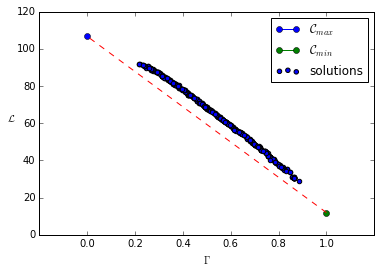

In [12]:
from deap import creator
from deap.base import Toolbox, Fitness
from deap.tools import selNSGA2, mutPolynomialBounded, cxSimulatedBinaryBounded
from deap.tools import initRepeat, initIterate, Statistics, emo
from deap.algorithms import eaSimple, eaMuPlusLambda
from operator import attrgetter
from copy import deepcopy


toolbox = Toolbox()

def uniform(low, up, size=None):
    return [random.uniform(a, b) for a, b in zip(low, up)]
toolbox.register("attr_float", uniform, df.freq_min.tolist(), df.freq_max.tolist())
toolbox.register("individual", initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", initRepeat, list, toolbox.individual)

# Evaluation fonction
toolbox.register("evaluate", fitness)

# On utilise la même méthode de sélection que dans le papier
toolbox.register("select", selNSGA2)

# Executes a simulated binary crossover that modify in-place the input individuals.
# The simulated binary crossover expects sequence individuals of floating point numbers.
toolbox.register("mate", cxSimulatedBinaryBounded, 
                 low=df.freq_min.tolist(), up=df.freq_max.tolist(), 
                 eta=10)

toolbox.cx_prob = 0.9

# Mutation classique en NSGA2
toolbox.register("mutate", mutPolynomialBounded, 
                 low=df.freq_min.tolist(), up=df.freq_max.tolist(), 
                 eta=20.0, indpb=1.0/N)

# Mutation probability
toolbox.mut_prob = 0.5

fit_stats = Statistics(key=attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)
fit_stats.register('max', np.max)
#fit_stats.register("pop", deepcopy)

toolbox.pop_size = 500
toolbox.ngen = 30
pop = toolbox.population(n=toolbox.pop_size)

# This is just to assign the crowding distance to the individuals
# no actual selection is done
pop = toolbox.select(pop, len(pop))

scaling = 125

result, logs = eaMuPlusLambda(pop, toolbox, ngen=toolbox.ngen,
                              lambda_=toolbox.pop_size, mu=toolbox.pop_size, 
                              cxpb=1 - toolbox.mut_prob, mutpb=toolbox.mut_prob, 
                              verbose=True, stats=fit_stats)
temp = pd.DataFrame([(np.mean(satisfaction(x)), 
                      lifetime(g, x, df.t_request)[1]/scaling) 
                     for x in result if not any(np.isnan(x))],
                    columns=["satisfaction", "lifetime"])
# Plotting part
if True:
    fig, ax = plt.subplots()
    temp.plot(x="satisfaction", y="lifetime", ax=ax, kind='scatter', label="solutions")
    ax.plot(np.mean(satisfaction(df.freq_max)), 
            lifetime(g, df.freq_max, df.t_request)[1]/scaling, 
            marker='o', label='$\mathcal{C}_{max}$')
    ax.plot(np.mean(satisfaction(df.freq_min)), 
            lifetime(g, df.freq_min, df.t_request)[1]/scaling, 
            marker='o', label="$\mathcal{C}_{min}$")
    ax.plot([np.mean(satisfaction(df.freq_min)),np.mean(satisfaction(df.freq_max))], 
            [lifetime(g, df.freq_min, df.t_request)[1]/scaling, 
             lifetime(g, df.freq_max, df.t_request)[1]/scaling],
            "--")
    ax.set_xlabel("$\Gamma$")
    ax.set_ylabel("$\mathcal{L}$", rotation=0)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.legend()
    fig.savefig("test_pareto.pdf")

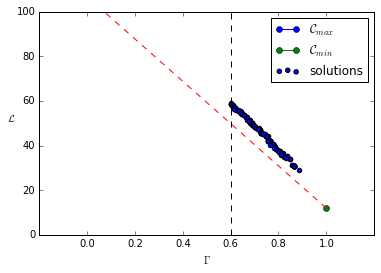

In [34]:
if True:
    fig, ax = plt.subplots()
    temp[temp.satisfaction > 0.6].plot(x="satisfaction", y="lifetime", ax=ax, kind='scatter', label="solutions")
    ax.plot(np.mean(satisfaction(df.freq_max)), 
            lifetime(g, df.freq_max, df.t_request)[1]/scaling, 
            marker='o', label='$\mathcal{C}_{max}$')
    ax.plot(np.mean(satisfaction(df.freq_min)), 
            lifetime(g, df.freq_min, df.t_request)[1]/scaling, 
            marker='o', label="$\mathcal{C}_{min}$")
    ax.plot([np.mean(satisfaction(df.freq_min)),np.mean(satisfaction(df.freq_max))], 
            [lifetime(g, df.freq_min, df.t_request)[1]/scaling, 
             lifetime(g, df.freq_max, df.t_request)[1]/scaling],
            "--")
    ax.plot((0.6,0.6), (0, 100), "k--")
    ax.set_ylim((0, 100))
    ax.set_xlabel("$\Gamma$")
    ax.set_ylabel("$\mathcal{L}$", rotation=0)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.legend()
    fig.savefig("test_pareto.pdf")

In [33]:
temp[temp.satisfaction > 0.6].lifetime.max()

59.118595217590517

In [ ]:
numbers = [np.binary_repr(i, width=N) for i in np.arange(2**(N))]

def f(x):
    res = []
    for i in x:
        solution = np.zeros(N)
        for ind, letter in enumerate(i):
            if letter == "0":
                solution[ind] = df.freq_min[ind]
            else:
                solution[ind] = df.freq_max[ind]
        res.append(solution)
    return res
extremes = f(numbers)
fig_ex, ax_ex = plt.subplots()
for point in extremes:    
    ax_ex.plot(np.mean(satisfaction(point)), 
            lifetime(g, point, df.t_request), 
            marker='o')

In [ ]:
for r in result:
    print(satisfaction(r))

### Création de traffic de Zipf

D'abord, il faut créer un classement des noeuds les plus sollicités. 

In [ ]:
np.random.permutation(g.nodes())

Ensuite le traffic est proportionnel du noeud $i$ est $\frac{\lambda}{i}$ où $\lambda$ est le traffic vers le noeud le plus sollicité

In [ ]:
1 / np.arange(1, len(g.nodes()) + 1)

On a toujours un trafic poissonien cependant le rythme des variables est différent selon la popularité du contenu

In [ ]:
lifetime(g, 
         [10 for x in range(len(g.nodes()))], 
         [0.1 for x in range(len(g.nodes()))])

In [ ]:
df_l = pd.concat(
        [pd.DataFrame({"c": pd.Series(np.arange(0.5, 10)),
                       "T": t}) for t in [0.5, 1, 2]])
l_vector = lambda x: lifetime(g, 
                                [x[0] for _ in range(len(g.nodes()))],
                                [x[1] for _ in range(len(g.nodes()))])[1]

df_l["lifetime"] = df_l.apply(l_vector,axis=1)
df_l.set_index("c", inplace=True)
#df_l.groupby("T").plot()
for i, group in df_l.groupby("T"):
    plt.figure()
    group.plot()
